In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [110]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

ITEM_COL = 'item_id'
USER_COL = 'user_id'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

train_full = data_train_matcher

# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()


# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

C:\Users\lufta\Documents\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


In [111]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [112]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [113]:
ACTUAL_COL = 'actual'

In [114]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [115]:
# N = Neighbors
N_PREDICT = 50 

In [116]:
# # сырой и простой пример как можно обернуть в функцию
def evalRecall(df_result, target_col_name, recommend_model, N_PREDICT, col_name):
    result_col_name = col_name
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N_PREDICT))
    return col_name, df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [117]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [118]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [119]:
def topRecall(df_result, target_col_name, N_PREDICT):
    overall_top_purchases = recommender.overall_top_purchases[:N_PREDICT]
    col_name = 'top'
    df_result['top'] = df_result[USER_COL].apply(lambda x: overall_top_purchases)
    return col_name, df_result.apply(lambda row: recall_at_k(row['top'], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean() 

In [120]:
def recommend(n):
    recall_top = topRecall(result_eval_matcher, USER_COL, n)
    recall_als = evalRecall(result_eval_matcher, USER_COL, recommender.get_als_recommendations, n, 'als')
    recall_own = evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations, n, 'own')
    recall_sim = evalRecall(result_eval_matcher, USER_COL, recommender.get_similar_items_recommendation, n, 'sim')
    rec = [recall_top, recall_als, recall_own, recall_sim]
    return rec

In [121]:
recommend(50)

[('top', 0.04323684353105271),
 ('als', 0.048058625668721815),
 ('own', 0.06525657038145175),
 ('sim', 0.033572621756695266)]

**Как видно, recommendtions + top-popular показывают лучший recall, чем просто top-popular.**

In [122]:
def selection(n_list):
    selection_df = pd.DataFrame()
    for n in n_list:
        recall = evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations, n, 'recall')
        selection_df = selection_df.append(pd.DataFrame([recall[1]], columns=['recall'], index=[n]))
    return selection_df

In [123]:
n_list = [10, 20, 50, 100, 200, 250, 300, 400, 500]

In [124]:
selection_df = selection(n_list)

In [125]:
selection_df['growth'] = (selection_df['recall'] - selection_df['recall'].shift(1)).fillna(0)

In [126]:
selection_df['growth_%'] = ((selection_df['recall'] / selection_df['recall'].shift(1))-1).fillna(0)

In [127]:
selection_df

,recall,growth,growth_%
10,0.026872,0.000000,0.000000
20,0.039284,0.012412,0.461906
50,0.065257,0.025972,0.661137
100,0.096045,0.030788,0.471805
200,0.135373,0.039328,0.409474
250,0.147945,0.012572,0.092871
300,0.157184,0.009239,0.062450
400,0.171806,0.014622,0.093022
500,0.182053,0.010247,0.059645


<AxesSubplot:>

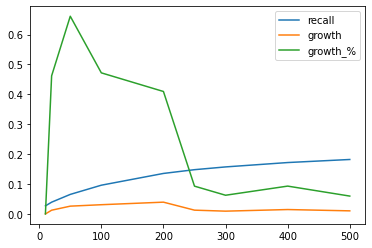

In [128]:
selection_df.plot()

**В целом с увеличением k увеличивается и recall, что логично.**

**Думаю, что для обычной ситуации лучше использовать минимальное кол-во рекомендаций (для пользователя магазина и т.д.). хотя, например, если это рекомендации для организаций, то можно использовать большее кол-во. Опитамально до 200, т.к. после 200 прирост увеличения recall сильно снижается**

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [148]:
def new_features(data, user_features, item_features):
    
    #for user
    average_data = data[['user_id', 'basket_id', 'sales_value']].copy()
    average_check = average_data.groupby('basket_id').agg('mean').groupby('user_id',as_index=False).agg('mean').rename(columns={'sales_value': 'average_check'})
    user_features['average_check'] = user_features['user_id'].map(dict(average_check.values))
    
    #for item
    price_data = data[['item_id', 'quantity', 'sales_value']].copy()
    item_price = price_data.groupby('item_id', as_index=False).agg('sum')
    item_price['item_price'] = item_price['sales_value'] / item_price['quantity']
    item_price = item_price[['item_id', 'item_price']]
    item_features['item_price'] = item_features['item_id'].map(dict(item_price.values)).fillna(0)
    
    return user_features, item_features

In [149]:
user_features, item_features = new_features(data, user_features, item_features)

In [150]:
def train_test_preprocessing(data):    
    
    df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
    df_match_candidates.columns = [USER_COL]
    
    df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=50))
    
    df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    df_items.name = 'item_id'
    
    df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
    
    df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
    df_ranker_train['target'] = 1  # тут только покупки 
    
    
    df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

    # чистим дубликаты
    df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

    df_ranker_train['target'].fillna(0, inplace= True)
    
    df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
    df_ranker_train = df_ranker_train.drop_duplicates()
    df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')
    df_ranker_train = df_ranker_train.drop_duplicates()
    df_ranker_train = df_ranker_train.fillna(0)
    
    X_train = df_ranker_train.drop('target', axis=1)
    y_train = df_ranker_train[['target']]

    return df_ranker_train, X_train, y_train

In [151]:
df_ranker_train, X_train, y_train = train_test_preprocessing(data_train_matcher)

In [152]:
cat_feats = X_train.columns[2:].tolist()

In [153]:
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [154]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

G:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
G:\Anaconda\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [155]:
train_preds

array([[0.97731573, 0.02268427],
       [0.99005756, 0.00994244],
       [0.97980509, 0.02019491],
       ...,
       [0.98291633, 0.01708367],
       [0.87034741, 0.12965259],
       [0.94652694, 0.05347306]])

In [156]:
df_ranker_predict = df_ranker_train.copy()

In [157]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [158]:
df_ranker_predict['proba_item_purchase'][:10]

0    0.022684
1    0.009942
2    0.020195
3    0.000851
4    0.206912
5    0.031489
6    0.010122
7    0.001827
8    0.036338
9    0.386071
Name: proba_item_purchase, dtype: float64

In [159]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [160]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 7.87 s


In [161]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, 5), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

In [162]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [163]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [164]:
print(*sorted(calc_precision(result_eval_ranker, 5), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.161044386422975)
('own_rec', 0.1444117647058813)


C:\Users\lufta\Documents\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)
